### Area of Medical Services Shortage Classification (CNN Multi-Class)

1. Data was first pre-processed and load the final version of la_facility_mua.csv here

2. Since feature engineering has been done, a few touch-ups before training:

a) **Feature Mapping,**

b) **Dropping useless variables,**

c) **Datetime conversion,**

d) **Days Diff**

3. We have 51-classes of Zip Codes.

a) Group Zip Codes into **10** categories(0-9) based on **Severity of Shortage**

b) **9** represents the **Highest Shortage** while **0** represents the **Lowest Shortage**

c) Name the new variable as **'Zip Class'** which is our **Target** (what we will try to predict here)**

4. Data was split into Train and Validation

5. Model: CNN (Library: TensorFlow.Keras)


In [2]:
import os
os.environ['PYTHONHASHSEED']='0'

In [3]:
import pandas as pd
import numpy as np
import random as rn
# Deep Learning Libraries
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import Conv1D,MaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import tensorflow as tf
np.random.seed(37)
rn.seed(42)
tf.random.set_seed(42)
from keras import backend as K

Using TensorFlow backend.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from math import sqrt 
from sklearn.metrics import log_loss
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc,roc_auc_score
from catboost import CatBoostClassifier,Pool, cv
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

la_facility_mua = pd.read_csv('../input/la-final-data-2/la_facility_mua.csv')

In [5]:
la_facility_mua.head()

,source,cat1,cat2,org_name,Name,addrln1,city,state,post_id,description,...,facility_address_1,MUA_RuralStatus,MUA_Designated_Time,MUA_Designated_Date,MUA_MSSA_Name_1,MUA_Updated_Time,MUA_Updated_Date,MUA_Poverty,MUA_Score,MUA_Pct_100Poverty
0,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,415 South Union Avenue,Urban,1.067990e+12,2003-11-05,MSSA 78.2b (Pico Union/Westlake),1.067990e+12,2003-11-05,157757.0,51.0,0.0
1,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,600 St Paul Ave,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
2,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1125 W 6th St,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
3,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1225 Wilshire Boulevard,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
4,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1127 Wilshire Blvd,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0


In [9]:
zip_score = {
    'MUA_Score': ['mean'],
}
zip_score = la_facility_mua.groupby(['Zip Code']).agg(zip_score)
zip_score.columns = ['ByZipCode_' + ('_'.join(col).strip()) for col in zip_score.columns.values]
zip_score.reset_index(inplace=True)

In [10]:
zip_score = zip_score.sort_values(by=['ByZipCode_MUA_Score_mean'], ascending=True)

In [11]:
zip_score.head()

,Zip Code,ByZipCode_MUA_Score_mean
18,90044,48.350000
7,90013,50.200000
15,90037,50.857143
5,90011,50.914286
2,90006,51.000000


In [12]:
la_facility_mua['Zip Class'] = la_facility_mua['Zip Code'].map({
90044:9, 90013:9, 90037:9, 90011:9, 90006:9,
90002:8, 90059:8, 90047:8, 90255:8, 90018:8,
90007:7, 90221:7, 90003:7, 90015:7, 90010:7,
90012:6, 91601:6, 90220:6, 90057:6, 91606:6,
91767:5, 91768:5, 91766:5, 90043:5, 90302:5,
90033:4, 90262:4, 91770:4, 91731:4, 90248:4,
91205:3, 91101:3, 90026:3, 91605:3, 90017:3,
90813:2, 91340:2, 90802:2, 90805:2, 90806:2,
90020:1, 91331:1, 90042:1, 90031:1, 90250:1,
91401:0, 91405:0, 90731:0, 91406:0, 90744:0, 91411:0})

la_facility_mua['Zip Class'] = la_facility_mua['Zip Class'].astype('int32')

In [13]:
la_facility_mua['Zip Class'].value_counts().sort_values(ascending=False)

0    2094
6    2067
7    1242
2    1230
4    1013
3     961
9     613
1     455
5     453
8     377
Name: Zip Class, dtype: int64

In [14]:
la_facility_mua.rename({'cat1': 'Category Service'}, axis=1, inplace=True)

In [15]:
la_facility_mua['Category Service'].value_counts().sort_values(ascending=False)

Health and Mental Health    4858
Social Services             4330
Public Safety               1317
Name: Category Service, dtype: int64

In [16]:
la_facility_mua['Category Service']=la_facility_mua['Category Service'].map({
'Health and Mental Health':0,
'Social Services':1,
'Public Safety':2
})
la_facility_mua['Category Service']=la_facility_mua['Category Service'].astype('int32')

In [18]:
la_facility_mua['facility_er_service'] = la_facility_mua['facility_er_service'].map({
'Not Applicable':'Not Applicable',
'None':'Not Applicable',
'Emergency - Basic':'Emergency',
'Emergency - Comprehensive':'Emergency',
'Emergency - Standby':'Emergency'
})

In [19]:
la_facility_mua['MUA_Poverty']=la_facility_mua['MUA_Poverty'].map({
157757.0:2,
129447.0:1,
0.0:0,
})

In [24]:
la_facility_mua['MUA_Designated_Date'] = pd.to_datetime(la_facility_mua['MUA_Designated_Date']) 
la_facility_mua['MUA_Updated_Date'] = pd.to_datetime(la_facility_mua['MUA_Updated_Date']) 
la_facility_mua['Date Difference'] = la_facility_mua['MUA_Updated_Date']-la_facility_mua['MUA_Designated_Date']

In [25]:
def ddiff2days(ddiff):
    if not pd.isnull(ddiff):
        return pd.Timedelta.total_seconds(ddiff)/(24.*3600)
    else:
        return np.NaN

In [26]:
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].apply(ddiff2days)
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].astype('int32')

In [27]:
la_facility_mua['design_year'] = (la_facility_mua['MUA_Designated_Date'].dt.year).astype('int32')
la_facility_mua['design_month'] = (la_facility_mua['MUA_Designated_Date'].dt.month).astype('int32')
la_facility_mua['design_week'] = (la_facility_mua['MUA_Designated_Date'].dt.week).astype('int32')
la_facility_mua['design_dow'] = (la_facility_mua['MUA_Designated_Date'].dt.dayofweek).astype('int32')

la_facility_mua['update_year'] = (la_facility_mua['MUA_Updated_Date'].dt.year).astype('int32')
la_facility_mua['update_month'] = (la_facility_mua['MUA_Updated_Date'].dt.month).astype('int32')
la_facility_mua['update_week'] = (la_facility_mua['MUA_Updated_Date'].dt.week).astype('int32')
la_facility_mua['update_dow'] = (la_facility_mua['MUA_Updated_Date'].dt.dayofweek).astype('int32')

In [29]:
la_facility_mua.drop(['MUA_Designated_Date', 'MUA_Updated_Date', 'Zip Code',                  
 ], axis=1, inplace=True)

In [30]:
cols = [c for c in la_facility_mua.columns if la_facility_mua[c].dtypes=='object']
for c in cols:
    le = LabelEncoder()
    la_facility_mua[c] = (le.fit_transform(la_facility_mua[c])).astype('int32')

In [32]:
X = la_facility_mua.drop(labels=['Zip Class'], axis=1)
y = la_facility_mua['Zip Class']

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=tf.random.set_seed(42))

In [33]:
X_train = X_train.to_numpy()
X_cv = X_cv.to_numpy()

In [34]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_cv = X_cv.reshape(X_cv.shape[0],X_cv.shape[1],1)

In [35]:
# Convolutional Neural Networks (CNN)
epoch = 180
model = Sequential()
model.add(Conv1D(40,2,activation='relu', kernel_initializer='he_normal',input_shape = X_train[0].shape))
model.add(Conv1D(100,2,activation='relu', kernel_initializer='he_normal'))
model.add(Conv1D(60,2,activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(50,activation='relu', kernel_initializer='he_normal'))
model.add(Dense(10,activation='softmax'))

In [36]:
model.compile(optimizer=Adam(lr=0.001), loss = 'sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [37]:
earlystop = EarlyStopping(patience=26) 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.96, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath='CNN_AreaShortage', monitor='val_accuracy', verbose=1, 
                save_best_only=True, mode='max', period=1)
callbacks = [#earlystop, 
             learning_rate_reduction, checkpointer
            ]

In [38]:
history = model.fit(X_train, y_train, epochs=epoch, 
                    validation_data=(X_cv, y_cv), 
                    callbacks=callbacks,
                    verbose=1)

Train on 7878 samples, validate on 2627 samples
Epoch 1/180
7808/7878 [============================>.] - ETA: 0s - loss: 1.8131 - accuracy: 0.3651
Epoch 00001: val_accuracy improved from -inf to 0.52684, saving model to CNN_AreaShortage
7878/7878 [==============================] - 9s 1ms/sample - loss: 1.8085 - accuracy: 0.3665 - val_loss: 1.2496 - val_accuracy: 0.5268
Epoch 2/180
7776/7878 [============================>.] - ETA: 0s - loss: 1.2216 - accuracy: 0.5460
Epoch 00002: val_accuracy improved from 0.52684 to 0.61972, saving model to CNN_AreaShortage
7878/7878 [==============================] - 7s 844us/sample - loss: 1.2157 - accuracy: 0.5479 - val_loss: 0.9831 - val_accuracy: 0.6197
Epoch 3/180
7808/7878 [============================>.] - ETA: 0s - loss: 1.0717 - accuracy: 0.5934
Epoch 00003: val_accuracy improved from 0.61972 to 0.67301, saving model to CNN_AreaShortage
7878/7878 [==============================] - 7s 881us/sample - loss: 1.0721 - accuracy: 0.5934 - val_loss: 

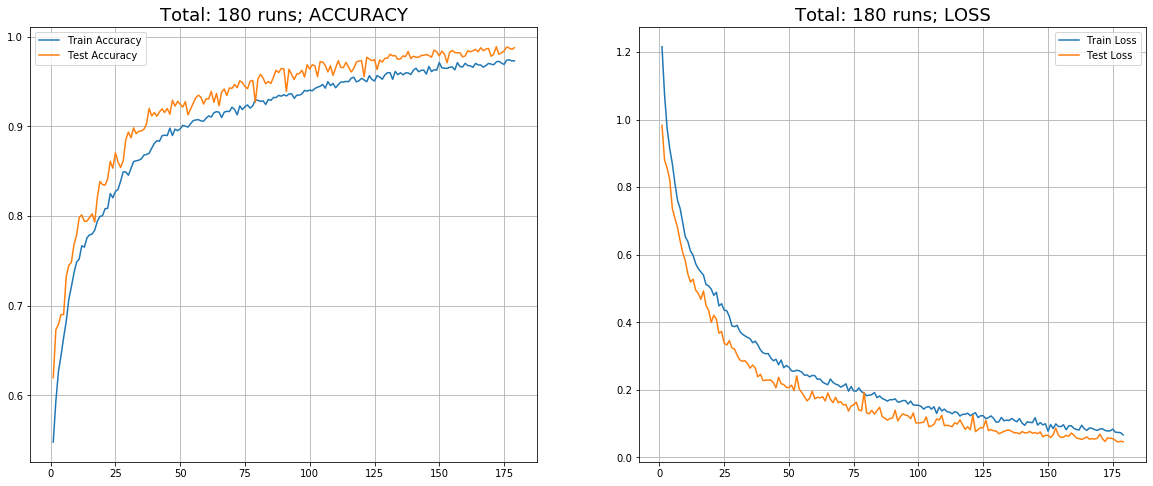

In [39]:
def plot_acc_loss(history, epochs):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train Accuracy')
    plt.plot(range(1,epochs), val_acc[1:], label='Test Accuracy')
    plt.title('Total: ' + str(epochs) + ' runs; '+'ACCURACY', size=18)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train Loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test Loss')
    plt.title('Total: ' + str(epochs) + ' runs; '+'LOSS', size=18)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(history, 180)